In [1]:
import tensorflow as tf
print(tf.__version__)


2.20.0


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model


In [3]:
DATASET_ROOT = r"C:\Users\saptg\anaconda_projects\0059300d-d57a-4ccf-9060-af72d9236304\dataset"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16


In [4]:
os.makedirs(DATASET_ROOT + "/train/organic", exist_ok=True)
os.makedirs(DATASET_ROOT + "/train/recyclable", exist_ok=True)

os.makedirs(DATASET_ROOT + "/validation/organic", exist_ok=True)
os.makedirs(DATASET_ROOT + "/validation/recyclable", exist_ok=True)

os.makedirs(DATASET_ROOT + "/test/organic", exist_ok=True)
os.makedirs(DATASET_ROOT + "/test/recyclable", exist_ok=True)


In [5]:
import shutil

source_O = DATASET_ROOT + "/O"
source_R = DATASET_ROOT + "/R" if os.path.exists(DATASET_ROOT + "/R") else None

images_O = os.listdir(source_O)
images_R = os.listdir(source_R) if source_R else images_O  # fallback

for split in ["train", "validation", "test"]:
    for img in images_O[:30]:
        shutil.copy(
            os.path.join(source_O, img),
            os.path.join(DATASET_ROOT, split, "organic")
        )
    for img in images_R[:30]:
        shutil.copy(
            os.path.join(source_R if source_R else source_O, img),
            os.path.join(DATASET_ROOT, split, "recyclable")
        )

print("Images copied successfully")


Images copied successfully


In [6]:
print("Train organic:", len(os.listdir(DATASET_ROOT + "/train/organic")))
print("Train recyclable:", len(os.listdir(DATASET_ROOT + "/train/recyclable")))


Train organic: 30
Train recyclable: 30


In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    DATASET_ROOT + "/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator = val_datagen.flow_from_directory(
    DATASET_ROOT + "/validation",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    DATASET_ROOT + "/test",
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)


Found 60 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [8]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(2, activation="softmax")(x)

extract_feat_model = Model(inputs=base_model.input, outputs=output)


In [9]:
extract_feat_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
extract_feat_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [11]:
history_feat = extract_feat_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)


C:\Users\saptg\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.5000 - loss: 4.7852 - val_accuracy: 0.5000 - val_loss: 6.3644
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.5000 - loss: 6.9766 - val_accuracy: 0.5000 - val_loss: 1.8585
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.4500 - loss: 4.0520 - val_accuracy: 0.5000 - val_loss: 4.3546
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.4333 - loss: 4.2479 - val_accuracy: 0.5000 - val_loss: 0.8939
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.5833 - loss: 1.9419 - val_accuracy: 0.5000 - val_loss: 2.4879
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.4333 - loss: 2.8089 - val_accuracy: 0.5000 - val_loss: 0.9537
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.4667 - loss: 1.4540 - val_accuracy: 0.5000 - val_loss: 0.9284
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.5000 - loss: 1.2684 - val_accuracy: 0.5000 - val_loss: 0.8039
Epoch 9/

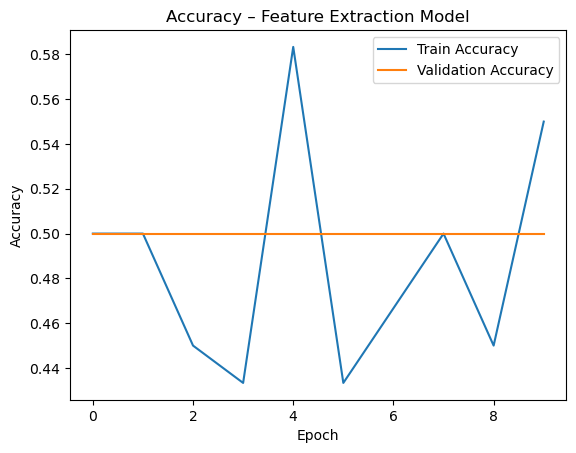

In [12]:
plt.plot(history_feat.history["accuracy"], label="Train Accuracy")
plt.plot(history_feat.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy – Feature Extraction Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


In [13]:
for layer in extract_feat_model.layers[-4:]:
    layer.trainable = True

extract_feat_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = extract_feat_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.4833 - loss: 0.7851 - val_accuracy: 0.5000 - val_loss: 0.7148
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.4500 - loss: 0.8362 - val_accuracy: 0.5000 - val_loss: 0.7116
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.5833 - loss: 0.6885 - val_accuracy: 0.5000 - val_loss: 0.7092
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.5667 - loss: 0.7319 - val_accuracy: 0.5000 - val_loss: 0.7074
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.5833 - loss: 0.6776 - val_accuracy: 0.5000 - val_loss: 0.7069
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.3833 - loss: 0.8321 - val_accuracy: 0.5000 - val_loss: 0.7055
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 11s/step - accuracy: 0.5167 - loss: 0.7881 - val_accuracy: 0.5000 - val_loss: 0.7036
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.5167 - loss: 0.6590 - val_accuracy: 0.5000 - val_loss: 0.7024
Epoch 9

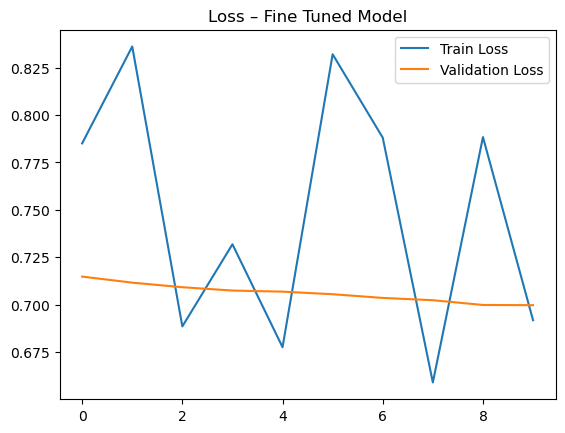

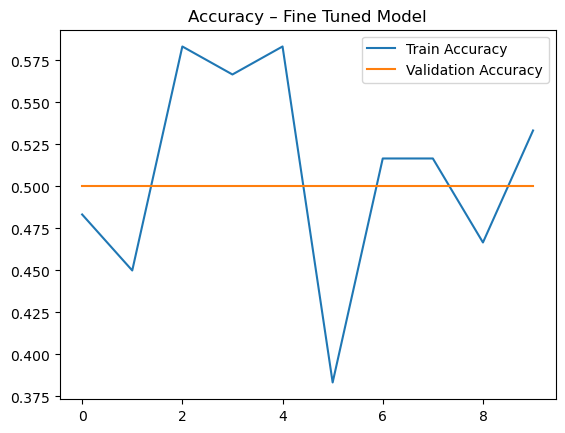

In [14]:
plt.plot(history_fine.history["loss"], label="Train Loss")
plt.plot(history_fine.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss – Fine Tuned Model")
plt.show()

plt.plot(history_fine.history["accuracy"], label="Train Accuracy")
plt.plot(history_fine.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy – Fine Tuned Model")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step


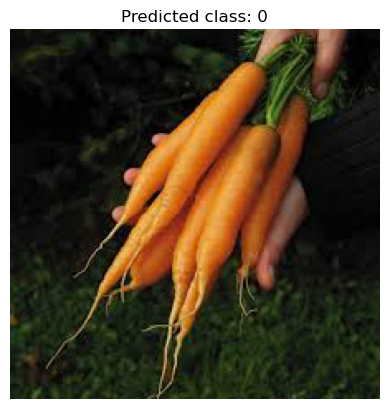

In [15]:
index_to_plot = 1

img, label = test_generator[index_to_plot]
prediction = extract_feat_model.predict(img)

plt.imshow(img[0])
plt.title(f"Predicted class: {np.argmax(prediction)}")
plt.axis("off")
plt.show()
